In [1]:
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import (
    balanced_accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, classification_report
)
import itertools
import os
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
os.chdir("D:\\mywork\\lincGNN\\cal")

D:\work\conda\ana\envs\RecGCN\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
D:\work\conda\ana\envs\RecGCN\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
D:\work\conda\ana\envs\RecGCN\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
edges_df = pd.read_csv('Net_final.csv', index_col=0)
print(edges_df)

for col in edges_df.columns[0:]:
    print(f"distribution - {col}:")
    print(edges_df[col].value_counts())
    print("\n")


       Regulator       Target RegulatorType TargetType regulatory_Mechanism
1          NEAT1   miR-194-5p        lncRNA      miRNA      ceRNA or sponge
2      LINC00460      miR-206        lncRNA      miRNA      ceRNA or sponge
3         MALAT1      miR-497        lncRNA      miRNA      ceRNA or sponge
4           MIAT      miR-29b        lncRNA      miRNA      ceRNA or sponge
5     CDKN2B-AS1  miR-181a-5p        lncRNA      miRNA      ceRNA or sponge
...          ...          ...           ...        ...                  ...
9513       WWTR1         YAP1           PCG        PCG            interacts
9514        YAP1        YWHAH           PCG        PCG            interacts
9515        YAP1        YWHAZ           PCG        PCG            interacts
9516        YAP1         YES1           PCG        PCG            interacts
9517       YWHAH        YWHAZ           PCG        PCG            interacts

[9517 rows x 5 columns]
distribution - Regulator:
MALAT1       258
HOTAIR       208
H19

In [3]:
edges_df.columns = ['A', 'B', 'A_type', 'B_type', 'relation']
print(edges_df)

               A            B  A_type B_type         relation
1          NEAT1   miR-194-5p  lncRNA  miRNA  ceRNA or sponge
2      LINC00460      miR-206  lncRNA  miRNA  ceRNA or sponge
3         MALAT1      miR-497  lncRNA  miRNA  ceRNA or sponge
4           MIAT      miR-29b  lncRNA  miRNA  ceRNA or sponge
5     CDKN2B-AS1  miR-181a-5p  lncRNA  miRNA  ceRNA or sponge
...          ...          ...     ...    ...              ...
9513       WWTR1         YAP1     PCG    PCG        interacts
9514        YAP1        YWHAH     PCG    PCG        interacts
9515        YAP1        YWHAZ     PCG    PCG        interacts
9516        YAP1         YES1     PCG    PCG        interacts
9517       YWHAH        YWHAZ     PCG    PCG        interacts

[9517 rows x 5 columns]


In [4]:
lnc_feat_df = pd.read_csv('Label_final.csv', index_col=0)
print(lnc_feat_df)

      Regulator  cell_proliferation_label  length  GC_content    A_freq  \
1       A2M-AS1                         1    2930    0.429693  0.282253   
2         AATBC                         1    4598    0.614180  0.221618   
3        ABALON                         0    1903    0.565423  0.216500   
4     ACTA2-AS1                         1    2450    0.483265  0.267347   
5      ACTG1P25                         1    2321    0.506247  0.234382   
..          ...                       ...     ...         ...       ...   
601       ZFAS1                         1    4527    0.463000  0.230616   
602   ZFHX4-AS1                         0    5012    0.348763  0.323224   
603   ZFPM2-AS1                         0    1655    0.373414  0.284592   
604  ZNF407-AS1                         1    4931    0.421821  0.301764   
605  ZNF667-AS1                         1    5588    0.405691  0.289907   

       T_freq    G_freq    C_freq  dimer_AA  dimer_AC  ...  tetramer_TTCG  \
1    0.288055  0.20000

In [5]:
lncrna_cluster_features = pd.read_csv('lncRNA_cluster_features.csv')
lncrna_cluster_features.rename(columns={lncrna_cluster_features.columns[0]: 'Regulator'}, inplace=True)
print(lncrna_cluster_features.head())

lncRNA_emb =  pd.read_csv('lncRNA_emb_features.csv')
lncRNA_emb.rename(columns={lncRNA_emb.columns[0]: 'Regulator'}, inplace=True)
print(lncRNA_emb.head())

    Regulator  cluster_k2  cluster_k3  cluster_k4  cluster_k5  cluster_k6  \
0       NEAT1           0           2           3           3           4   
1   LINC00460           0           2           3           3           4   
2      MALAT1           0           2           1           2           4   
3        MIAT           0           2           1           2           4   
4  CDKN2B-AS1           0           2           1           2           1   

   cluster_k7  cluster_k8  cluster_k9  cluster_k10  cluster_k11  
0           0           0           7            6            9  
1           0           0           4            6            9  
2           0           0           7            1           10  
3           0           0           7            1            1  
4           0           0           7            1           10  
    Regulator  feature_1  feature_2  feature_3  feature_4  feature_5  \
0       NEAT1  -0.055863  -0.003457   0.064911   0.041244   0.041424 

In [6]:

merged_df = pd.merge(lnc_feat_df, lncrna_cluster_features, on='Regulator', how='inner')
merged_df = pd.merge(merged_df, lncRNA_emb, on='Regulator', how='inner')
#merged_df = pd.merge(lnc_feat_df, lncRNA_emb, on='Regulator', how='inner')
print(merged_df.head())

   Regulator  cell_proliferation_label  length  GC_content    A_freq  \
0    A2M-AS1                         1    2930    0.429693  0.282253   
1      AATBC                         1    4598    0.614180  0.221618   
2     ABALON                         0    1903    0.565423  0.216500   
3  ACTA2-AS1                         1    2450    0.483265  0.267347   
4   ACTG1P25                         1    2321    0.506247  0.234382   

     T_freq    G_freq    C_freq  dimer_AA  dimer_AC  ...  feature_119  \
0  0.288055  0.200000  0.229693       259       156  ...     0.043067   
1  0.164202  0.316007  0.298173       237       279  ...     0.152246   
2  0.218077  0.262218  0.303205       122        88  ...     0.017568   
3  0.249388  0.266122  0.217143       166       125  ...    -0.024900   
4  0.259371  0.231366  0.274882       127       136  ...     0.008745   

   feature_120  feature_121  feature_122  feature_123  feature_124  \
0     0.058663    -0.043484     0.030920     0.062948    -

In [7]:
lnc_feat_df = merged_df
new_order = ['Regulator', 'cell_proliferation_label'] + [col for col in lnc_feat_df.columns if col not in ['Regulator',
                                                                                                     'cell_proliferation_label']]

lnc_feat_df = lnc_feat_df[new_order]
print(lnc_feat_df.head())

cols = lnc_feat_df.columns.tolist()
new_cols = ['lncRNA', 'label'] + [f'feat_{i}' for i in range(1, len(cols)-1)]
lnc_feat_df.columns = new_cols

print(lnc_feat_df.head())

   Regulator  cell_proliferation_label  length  GC_content    A_freq  \
0    A2M-AS1                         1    2930    0.429693  0.282253   
1      AATBC                         1    4598    0.614180  0.221618   
2     ABALON                         0    1903    0.565423  0.216500   
3  ACTA2-AS1                         1    2450    0.483265  0.267347   
4   ACTG1P25                         1    2321    0.506247  0.234382   

     T_freq    G_freq    C_freq  dimer_AA  dimer_AC  ...  feature_119  \
0  0.288055  0.200000  0.229693       259       156  ...     0.043067   
1  0.164202  0.316007  0.298173       237       279  ...     0.152246   
2  0.218077  0.262218  0.303205       122        88  ...     0.017568   
3  0.249388  0.266122  0.217143       166       125  ...    -0.024900   
4  0.259371  0.231366  0.274882       127       136  ...     0.008745   

   feature_120  feature_121  feature_122  feature_123  feature_124  \
0     0.058663    -0.043484     0.030920     0.062948    -

In [8]:

X = lnc_feat_df.iloc[:, 2:].values
y = lnc_feat_df.iloc[:, 1].values


idx = np.arange(X.shape[0])
train_idx, test_idx = train_test_split(idx, test_size=0.2, random_state=42, stratify=y)
train_idx, val_idx  = train_test_split(train_idx, test_size=0.25, random_state=42, stratify=y[train_idx])


X_train, y_train = X[train_idx], y[train_idx]
X_val, y_val     = X[val_idx], y[val_idx]
X_test, y_test   = X[test_idx], y[test_idx]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

# -----------------------------------

# -----------------------------------
param_grid = list(itertools.product(
    [0.1, 1, 10],            # C
    ['linear', 'rbf']      # kernel
))

results = []

# -----------------------------------

# -----------------------------------
for C, kernel in param_grid:
    if kernel == 'linear':
        clf = SVC(C=C, kernel=kernel, probability=True, random_state=42)
    else:
        clf = SVC(C=C, kernel=kernel, probability=True, random_state=42)

    clf.fit(X_train_scaled, y_train)
    y_val_pred = clf.predict(X_val_scaled)
    val_bal_acc = balanced_accuracy_score(y_val, y_val_pred)

    results.append({
        'C': C,
        'kernel': kernel,
        'val_bal_acc': val_bal_acc,
        'model': clf
    })

# -----------------------------------

# -----------------------------------
best_result = max(results, key=lambda x: x['val_bal_acc'])
best_clf = best_result['model']

print("\nBest hyperparameter combination (on validation set):")
print(f"C: {best_result['C']}")
print(f"kernel: {best_result['kernel']}")
print(f"Validation Balanced Accuracy: {best_result['val_bal_acc']:.4f}")

# -----------------------------------

# -----------------------------------
y_test_pred = best_clf.predict(X_test_scaled)
y_test_prob = best_clf.predict_proba(X_test_scaled)[:, 1]

bal_acc = balanced_accuracy_score(y_test, y_test_pred)
prec = precision_score(y_test, y_test_pred, zero_division=0)
rec = recall_score(y_test, y_test_pred, zero_division=0)
f1 = f1_score(y_test, y_test_pred, zero_division=0)
roc_auc = roc_auc_score(y_test, y_test_prob)

print("\n[Test Set Metrics]")
print(f"Balanced Accuracy: {bal_acc:.4f}")
print(f"Precision:         {prec:.4f}")
print(f"Recall:            {rec:.4f}")
print(f"F1-score:          {f1:.4f}")
print(f"ROC-AUC:           {roc_auc:.4f}")
print("\nClassification Report (Test Set):\n")
print(classification_report(y_test, y_test_pred, digits=4))


Best hyperparameter combination (on validation set):
C: 0.1
kernel: linear
Validation Balanced Accuracy: 0.5538

[Test Set Metrics]
Balanced Accuracy: 0.5692
Precision:         0.7935
Recall:            0.7935
F1-score:          0.7935
ROC-AUC:           0.6672

Classification Report (Test Set):

              precision    recall  f1-score   support

           0     0.3448    0.3448    0.3448        29
           1     0.7935    0.7935    0.7935        92

    accuracy                         0.6860       121
   macro avg     0.5692    0.5692    0.5692       121
weighted avg     0.6860    0.6860    0.6860       121



In [9]:
metrics = {
    "balanced_accuracy": bal_acc,
    "precision": prec,
    "recall": rec,
    "F1_score": f1,
    "ROC_AUC":roc_auc
}

metrics_df = pd.DataFrame(list(metrics.items()), columns=["metric", "value"])
print(metrics_df)
metrics_df.to_csv("ml_metrics.csv", index=False)

              metric     value
0  balanced_accuracy  0.569153
1          precision  0.793478
2             recall  0.793478
3           F1_score  0.793478
4            ROC_AUC  0.667166


[[10 19]
 [19 73]]


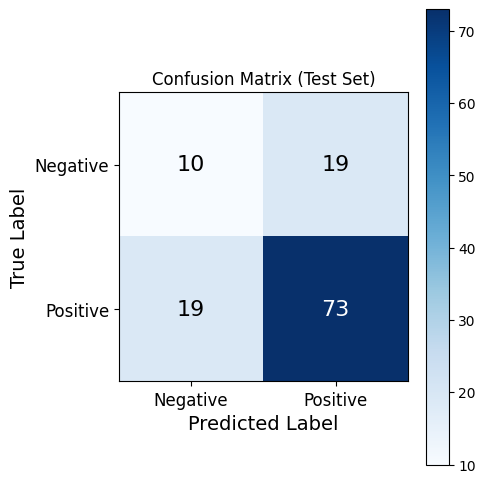

In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


cm = confusion_matrix(y_test, y_test_pred)
print(cm)
classes = ['Negative', 'Positive']  

plt.figure(figsize=(5, 5))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix (Test Set)')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, fontsize=12)
plt.yticks(tick_marks, classes, fontsize=12)

thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
             ha="center", va="center",
             color="white" if cm[i, j] > thresh else "black", fontsize=16)

plt.ylabel('True Label', fontsize=14)
plt.xlabel('Predicted Label', fontsize=14)
plt.tight_layout()
plt.savefig("ml_confusion_matrix.pdf")
plt.show()
